<a href="https://colab.research.google.com/github/rabnawaz172/Voice_pathology_2/blob/main/Voice_deep_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import numpy as np
import librosa
import pandas as pd
from sklearn.utils import shuffle

# Assuming the Google Drive dataset folder is loaded to a local directory using Google Colab
# Mount Google Drive first to access the files

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Processing 111 files in class 'Normal' from /content/drive/MyDrive/Voice_2/Train
Processing 117 files in class 'Pathol' from /content/drive/MyDrive/Voice_2/Train
Processing 47 files in class 'Normal' from /content/drive/MyDrive/Voice_2/Test_2
Processing 49 files in class 'Pathol' from /content/drive/MyDrive/Voice_2/Test_2


/usr/local/lib/python3.11/dist-packages/librosa/feature/spectral.py:2148: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 392ms/step - accuracy: 0.4981 - loss: 5.8134 - val_accuracy: 0.6087 - val_loss: 0.9740
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.5813 - loss: 2.0693 - val_accuracy: 0.8043 - val_loss: 0.5381
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5956 - loss: 0.7248 - val_accuracy: 0.6522 - val_loss: 0.6180
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6015 - loss: 0.6488 - val_accuracy: 0.6957 - val_loss: 0.6193
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6413 - loss: 0.5982 - val_accuracy: 0.7609 - val_loss: 0.5730
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6193 - loss: 0.5712 - val_accuracy: 0.8043 - val_loss: 0.4805
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6695 - loss: 0.5989 - val_accuracy: 0.8261 - val_loss: 0.4926
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7414 - loss: 0.4962 - val_accuracy: 0.7826 - val_loss

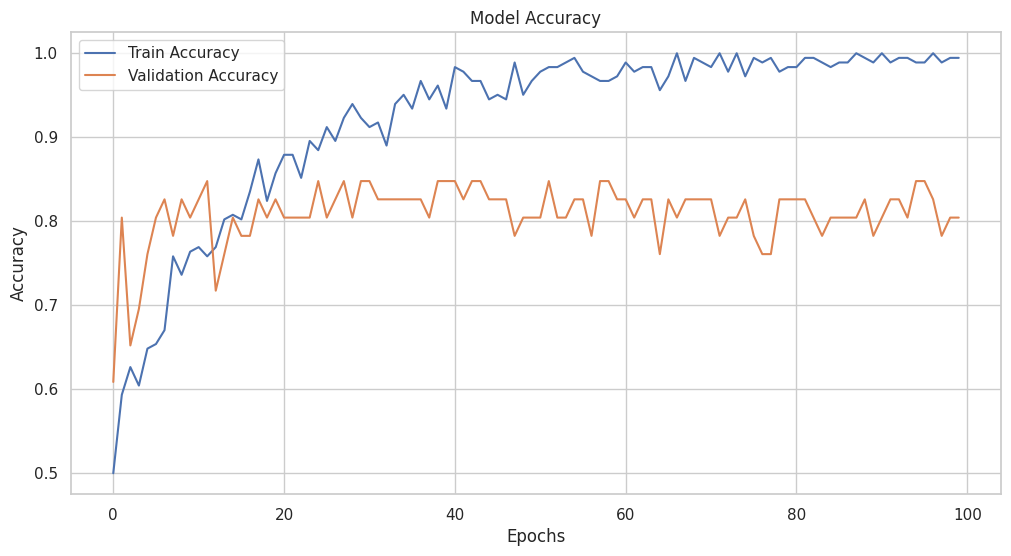

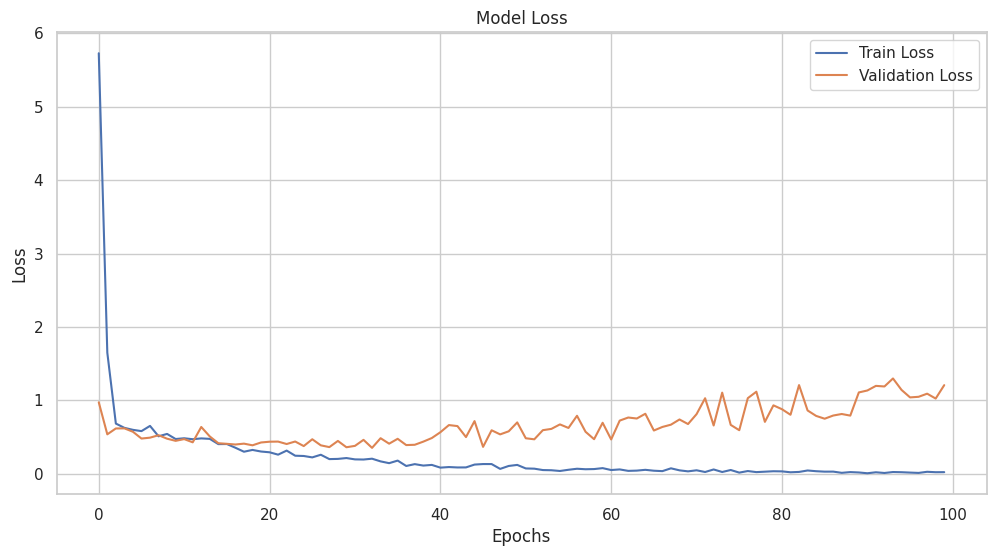

In [ ]:
import os
import numpy as np
import librosa
import glob
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

# Set seaborn style with grid
sns.set(style="whitegrid")

# Base paths
train_path = '/content/drive/MyDrive/Voice_2/Train'  # Training data
test_path = '/content/drive/MyDrive/Voice_2/Test_2'  # Separate test data

# Audio class labels
classes = ['Normal', 'Pathol']
labels = {'Normal': 0, 'Pathol': 1}

# Fixed audio length and Mel-spectrogram parameters
MAX_AUDIO_LENGTH = 16000  # 1 second at 16kHz
N_MELS = 64
TIME_STEPS = 32  # Desired time steps for model input

# Function to extract and process Mel-spectrogram
def extract_mel_spectrogram(file_path, max_len=MAX_AUDIO_LENGTH, time_steps=TIME_STEPS):
    try:
        y, sr = librosa.load(file_path, sr=None)

        # Pad or truncate audio to MAX_AUDIO_LENGTH
        if len(y) < max_len:
            y = np.pad(y, (0, max_len - len(y)), mode='constant')
        else:
            y = y[:max_len]

        # Extract Mel-spectrogram
        mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=N_MELS, fmax=8000)
        mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

        # Ensure time_steps = 32 by padding or truncating
        t = mel_spec_db.shape[1]
        if t < time_steps:
            pad_width = time_steps - t
            mel_spec_db = np.pad(mel_spec_db, pad_width=((0, 0), (0, pad_width)), mode='constant')
        elif t > time_steps:
            mel_spec_db = mel_spec_db[:, :time_steps]

        # Expand to 3 channels (RGB-like)
        mel_spec_db = np.expand_dims(mel_spec_db, axis=-1)
        mel_spec_db_rgb = np.repeat(mel_spec_db, 3, axis=-1)

        return mel_spec_db_rgb

    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return np.zeros((N_MELS, time_steps, 3))  # Return zero vector in case of error

# Function to load all data from a base path
def load_data(base_path, classes, labels):
    features = []
    targets = []
    for class_name in classes:
        class_path = os.path.join(base_path, class_name, '*.wav')
        file_list = glob.glob(class_path)
        print(f"Processing {len(file_list)} files in class '{class_name}' from {base_path}")
        for file in file_list:
            mel_spec = extract_mel_spectrogram(file)
            features.append(mel_spec)
            targets.append(labels[class_name])
    return np.array(features), np.array(targets)

# Load training data (used for train + validation)
X_train_val, y_train_val = load_data(train_path, classes, labels)

# Load test data (unseen, used only for final evaluation)
X_test, y_test = load_data(test_path, classes, labels)

# Split training data into train and validation (80% train, 20% val)
X_train, X_val, Y_train, Y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)

# Build the CNN model
model_hyb = models.Sequential([
    layers.InputLayer(input_shape=(N_MELS, TIME_STEPS, 3)),
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

model_hyb.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Train the model
history_hyb = model_hyb.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    epochs=100,
    batch_size=32,
    verbose=1
)

# Evaluate on validation data
Y_val_pred = (model_hyb.predict(X_val) > 0.5).astype(int)

val_accuracy = accuracy_score(Y_val, Y_val_pred)
val_precision = precision_score(Y_val, Y_val_pred)
val_recall = recall_score(Y_val, Y_val_pred)
val_f1 = f1_score(Y_val, Y_val_pred)

print(f"Validation Metrics - Accuracy: {val_accuracy:.4f}, Precision: {val_precision:.4f}, Recall: {val_recall:.4f}, F1 Score: {val_f1:.4f}")

# Evaluate on test data
Y_test_pred = (model_hyb.predict(X_test) > 0.5).astype(int)

test_accuracy = accuracy_score(y_test, Y_test_pred)
test_precision = precision_score(y_test, Y_test_pred)
test_recall = recall_score(y_test, Y_test_pred)
test_f1 = f1_score(y_test, Y_test_pred)

print(f"Test Metrics - Accuracy: {test_accuracy:.4f}, Precision: {test_precision:.4f}, Recall: {test_recall:.4f}, F1 Score: {test_f1:.4f}")

# Plot training history
plt.figure(figsize=(12, 6))
plt.plot(history_hyb.history['accuracy'], label='Train Accuracy')
plt.plot(history_hyb.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(history_hyb.history['loss'], label='Train Loss')
plt.plot(history_hyb.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Processing 111 files in class 'Normal'
Processing 117 files in class 'Pathol'
Processing 47 files in class 'Normal'
Processing 49 files in class 'Pathol'


/usr/local/lib/python3.11/dist-packages/librosa/feature/spectral.py:2148: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 332ms/step - accuracy: 0.5570 - loss: 1.9226 - val_accuracy: 0.7292 - val_loss: 0.5201
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.5769 - loss: 1.5604 - val_accuracy: 0.7708 - val_loss: 0.5142
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.5953 - loss: 1.2026 - val_accuracy: 0.6354 - val_loss: 0.5990
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.5020 - loss: 1.5100 - val_accuracy: 0.6458 - val_loss: 0.5833
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.6104 - loss: 1.0212 - val_accuracy: 0.8021 - val_loss: 0.4771
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.6798 - loss: 0.7906 - val_accuracy: 0.8125 - val_loss: 0.4428
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.6870 - loss: 0.8123 - val_accuracy: 0.8229 - val_loss: 0.4297
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.6495 - loss: 0.8557 - val_accuracy: 0.7708 - val_loss

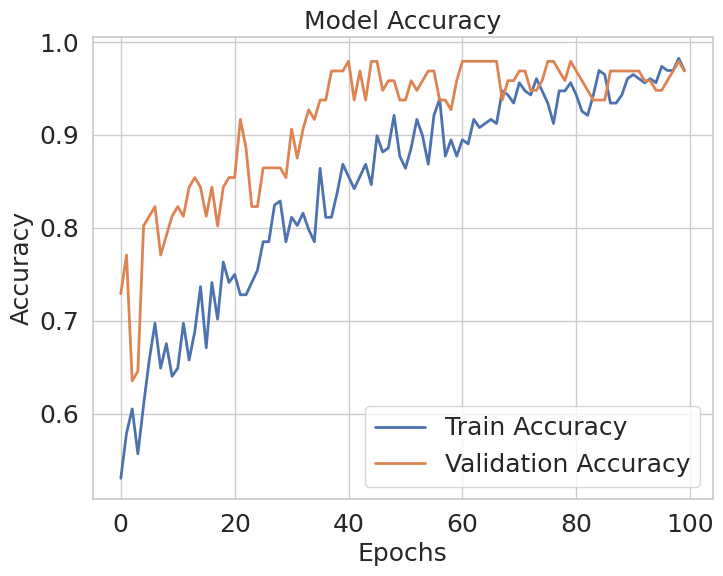

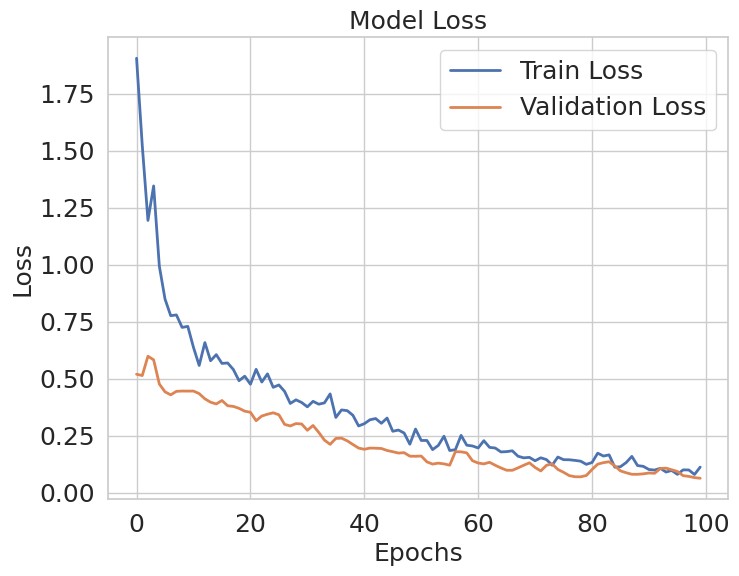

In [ ]:
import os
import numpy as np
import librosa
import glob
import tensorflow as tf
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG16

# Set seaborn style with grid
sns.set(style="whitegrid")

# Set base paths for training and validation
train_path = '/content/drive/MyDrive/Voice_2/Train'
test_path = '/content/drive/MyDrive/Voice_2/Test_2'

classes = ['Normal', 'Pathol']
labels = {'Normal': 0, 'Pathol': 1}

# Define the maximum audio length and padding
MAX_AUDIO_LENGTH = 16000  # 1 second of audio at 16 kHz sampling rate

# Function to extract Mel-spectrogram from the audio
def extract_mel_spectrogram(file_path, max_len=MAX_AUDIO_LENGTH):
    try:
        # Load audio file with librosa (no resampling)
        y, sr = librosa.load(file_path, sr=None)
        # If the audio is shorter than max_len, pad it with zeros
        if len(y) < max_len:
            pad_width = max_len - len(y)
            y = np.pad(y, (0, pad_width), mode='constant')
        # If the audio is longer than max_len, truncate it
        elif len(y) > max_len:
            y = y[:max_len]

        # Extract Mel-spectrogram
        mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=64, fmax=8000)
        mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

        # Reshape to match the input of the model (height, width, channels)
        mel_spec_db = np.expand_dims(mel_spec_db, axis=-1)  # Shape (64, time, 1)

        # Replicate the single channel to simulate RGB channels (64, time, 3)
        mel_spec_db_rgb = np.repeat(mel_spec_db, 3, axis=-1)

    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        mel_spec_db_rgb = np.zeros((64, 100, 3))  # Return a zero vector in case of error
    return mel_spec_db_rgb

def load_data(base_path, classes, labels):
    features = []
    target = []
    for class_name in classes:
        class_path = os.path.join(base_path, class_name, '*.wav')
        file_list = glob.glob(class_path)

        print(f"Processing {len(file_list)} files in class '{class_name}'")

        for file in file_list:
            mel_spec = extract_mel_spectrogram(file)
            features.append(mel_spec)
            target.append(labels[class_name])
    return np.array(features), np.array(target)

# Load training and validation data
X_train, Y_train = load_data(train_path, classes, labels)
X_val, Y_val = load_data(test_path, classes, labels)

# Build the VGGish model for transfer learning
# Load VGG16 as base model with pre-trained ImageNet weights
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(None, None, 3))

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers on top
x = layers.GlobalAveragePooling2D()(base_model.output)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.5)(x)
output = layers.Dense(1, activation='sigmoid')(x)

# Define the model
model_trans = Model(inputs=base_model.input, outputs=output)

# Compile the model
model_trans.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history_trans = model_trans.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    epochs=100,  # Adjust epochs as needed
    batch_size=32,  # Adjust batch size as needed
    verbose=1
)

# Evaluate the model
Y_val_pred_trans = (model_trans.predict(X_val) > 0.5).astype(int)

accuracy = accuracy_score(Y_val, Y_val_pred_trans)
precision = precision_score(Y_val, Y_val_pred_trans)
recall = recall_score(Y_val, Y_val_pred_trans)
f1 = f1_score(Y_val, Y_val_pred_trans)

print(f"Validation Metrics - Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F1 Score: {f1}")

plt.figure(figsize=(8, 6))
plt.plot(history_trans.history['accuracy'], label='Train Accuracy', linewidth=2)
plt.plot(history_trans.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
plt.title('Model Accuracy', fontsize=18)
plt.xlabel('Epochs', fontsize=18)
plt.ylabel('Accuracy', fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(fontsize=18)
plt.grid(True)
plt.show()

# Plot training loss history
plt.figure(figsize=(8, 6))
plt.plot(history_trans.history['loss'], label='Train Loss', linewidth=2)
plt.plot(history_trans.history['val_loss'], label='Validation Loss', linewidth=2)
plt.title('Model Loss', fontsize=18)
plt.xlabel('Epochs', fontsize=18)
plt.ylabel('Loss', fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(fontsize=18)
plt.grid(True)
plt.show()

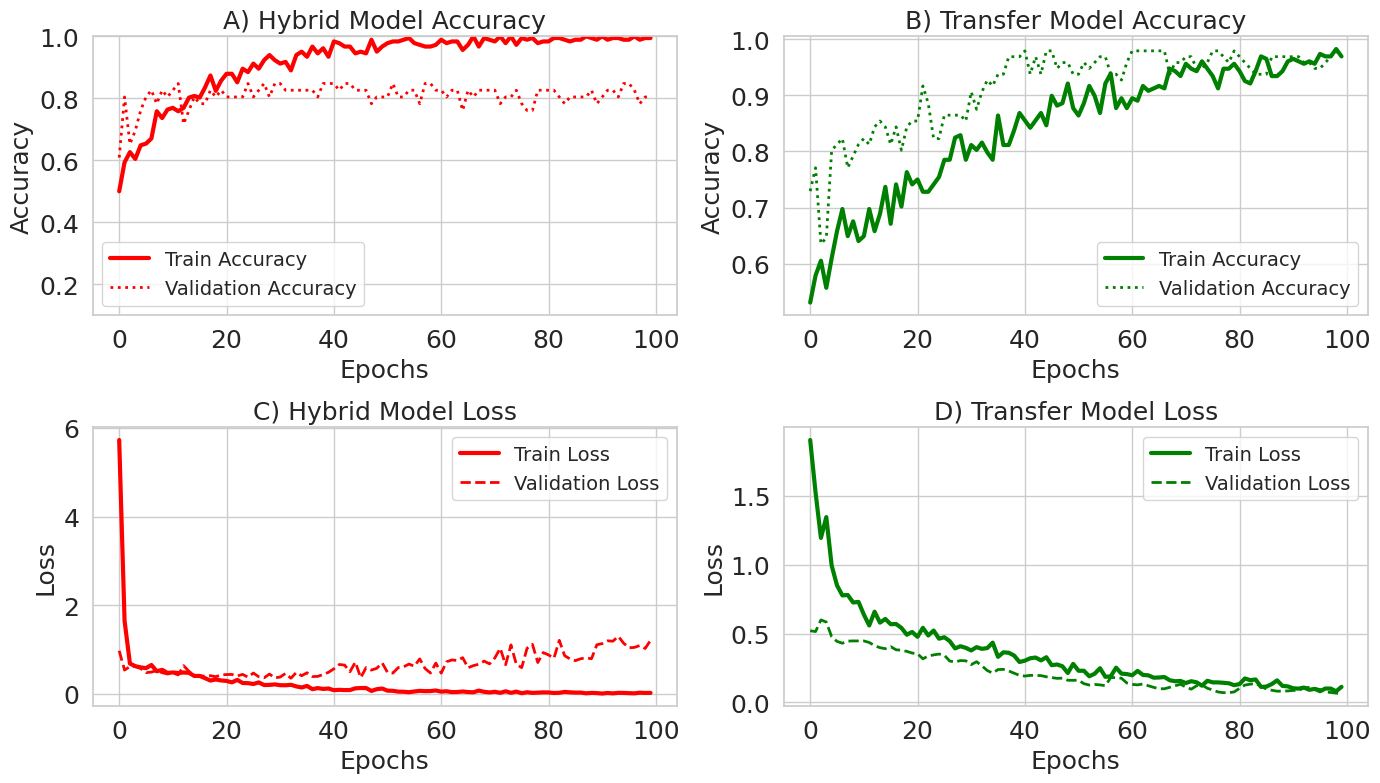

In [ ]:
import matplotlib.pyplot as plt

# Create a figure with 2 rows and 2 columns of subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 8))

# ----------------------------
# Subplot A: Hybrid Model - Accuracy
# ----------------------------
axes[0, 0].plot(history_hyb.history['accuracy'], label='Train Accuracy', linewidth=3, color='red')
axes[0, 0].plot(history_hyb.history['val_accuracy'], label='Validation Accuracy', linewidth=2, linestyle='dotted', color='red')
axes[0, 0].set_title('A) Hybrid Model Accuracy', fontsize=18)
axes[0, 0].set_xlabel('Epochs', fontsize=18)
axes[0, 0].set_ylabel('Accuracy', fontsize=18)
axes[0, 0].set_ylim(0.1, 1.0)  # Focus on 90% to 100% range
axes[0, 0].tick_params(axis='both', which='major', labelsize=18)
axes[0, 0].legend(fontsize=14)
axes[0, 0].grid(True)

# ----------------------------
# Subplot B: Transfer Model - Accuracy
# ----------------------------
axes[0, 1].plot(history_trans.history['accuracy'], label='Train Accuracy', linewidth=3, color='green')
axes[0, 1].plot(history_trans.history['val_accuracy'], label='Validation Accuracy', linewidth=2, linestyle='dotted', color='green')
axes[0, 1].set_title('B) Transfer Model Accuracy', fontsize=18)
axes[0, 1].set_xlabel('Epochs', fontsize=18)
axes[0, 1].set_ylabel('Accuracy', fontsize=18)
axes[0, 0].set_ylim(0.1, 1.0)
axes[0, 1].tick_params(axis='both', which='major', labelsize=18)
axes[0, 1].legend(fontsize=14)
axes[0, 1].grid(True)

# ----------------------------
# Subplot C: Hybrid Model - Loss
# ----------------------------
axes[1, 0].plot(history_hyb.history['loss'], label='Train Loss', linewidth=3, color='red')
axes[1, 0].plot(history_hyb.history['val_loss'], label='Validation Loss', linewidth=2, linestyle='dashed', color='red')
axes[1, 0].set_title('C) Hybrid Model Loss', fontsize=18)
axes[1, 0].set_xlabel('Epochs', fontsize=18)
axes[1, 0].set_ylabel('Loss', fontsize=18)


axes[1, 0].tick_params(axis='both', which='major', labelsize=18)
axes[1, 0].legend(fontsize=14)
axes[1, 0].grid(True)

# ----------------------------
# Subplot D: Transfer Model - Loss
# ----------------------------
axes[1, 1].plot(history_trans.history['loss'], label='Train Loss', linewidth=3, color='green')
axes[1, 1].plot(history_trans.history['val_loss'], label='Validation Loss', linewidth=2, linestyle='dashed', color='green')
axes[1, 1].set_title('D) Transfer Model Loss', fontsize=18)
axes[1, 1].set_xlabel('Epochs', fontsize=18)
axes[1, 1].set_ylabel('Loss', fontsize=18)

axes[1, 1].tick_params(axis='both', which='major', labelsize=18)
axes[1, 1].legend(fontsize=14)
axes[1, 1].grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the combined figure
plt.show()

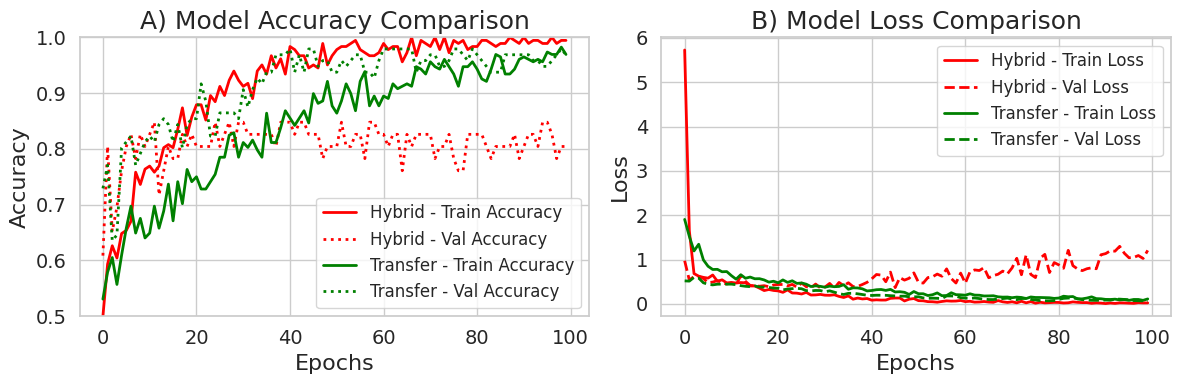

In [ ]:
import matplotlib.pyplot as plt

# Create a figure with 1 row and 2 columns of subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 4))  # Wider figure for side-by-side layout

# ----------------------------
# Subplot 0: Accuracy Comparison (Left)
# ----------------------------
# Hybrid model accuracy
axes[0].plot(history_hyb.history['accuracy'], label='Hybrid - Train Accuracy', linewidth=2, color='red')
axes[0].plot(history_hyb.history['val_accuracy'], label='Hybrid - Val Accuracy', linewidth=2, linestyle='dotted', color='red')

# Transfer learning model accuracy
axes[0].plot(history_trans.history['accuracy'], label='Transfer - Train Accuracy', linewidth=2, color='green')
axes[0].plot(history_trans.history['val_accuracy'], label='Transfer - Val Accuracy', linewidth=2, linestyle='dotted', color='green')

axes[0].set_title('A) Model Accuracy Comparison', fontsize=18)  # Added "A)"
axes[0].set_xlabel('Epochs', fontsize=16)
axes[0].set_ylabel('Accuracy', fontsize=16)
axes[0].set_ylim(0.5, 1.0)  # Focus on relevant range
axes[0].tick_params(axis='both', which='major', labelsize=14)
axes[0].legend(fontsize=12)
axes[0].grid(True)

# ----------------------------
# Subplot 1: Loss Comparison (Right)
# ----------------------------
# Hybrid model loss
axes[1].plot(history_hyb.history['loss'], label='Hybrid - Train Loss', linewidth=2, color='red')
axes[1].plot(history_hyb.history['val_loss'], label='Hybrid - Val Loss', linewidth=2, linestyle='dashed', color='red')

# Transfer learning model loss
axes[1].plot(history_trans.history['loss'], label='Transfer - Train Loss', linewidth=2, color='green')
axes[1].plot(history_trans.history['val_loss'], label='Transfer - Val Loss', linewidth=2, linestyle='dashed', color='green')

axes[1].set_title('B) Model Loss Comparison', fontsize=18)  # Added "B)"
axes[1].set_xlabel('Epochs', fontsize=16)
axes[1].set_ylabel('Loss', fontsize=16)
axes[1].tick_params(axis='both', which='major', labelsize=14)
axes[1].legend(fontsize=12)
axes[1].grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the combined figure
plt.show()

In [ ]:
model_hyb.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 64, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 32, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 16, 8, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │       524,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,631,429 (6.22 MB)

 Trainable params: 543,809 (2.07 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,087,620 (4.15 MB)

In [ ]:
model_trans.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, None, None, 64) │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, None, None, 64) │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, None, None, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, None, None,     │        73,856 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, None, None,     │       147,584 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, None, None,     │       295,168 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, None, None,     │     1,180,160 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │             

 Total params: 14,936,645 (56.98 MB)

 Trainable params: 73,985 (289.00 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

 Optimizer params: 147,972 (578.02 KB)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


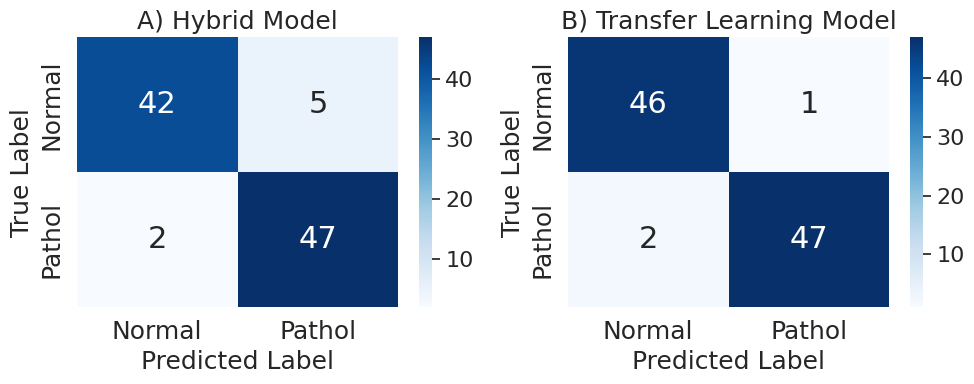

Model 1 Metrics:
Accuracy: 0.93
Precision: 0.90
Recall: 0.96
F1 Score: 0.93

Model 2 Metrics:
Accuracy: 0.97
Precision: 0.98
Recall: 0.96
F1 Score: 0.97


In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Predict on the validation set for model_1
Y_val_pred_prob_1 = model_hyb.predict(X_val)
Y_val_pred_1 = (Y_val_pred_prob_1 > 0.5).astype(int).flatten()  # Convert probabilities to binary predictions

# Compute confusion matrix for model_1
cm_1 = confusion_matrix(Y_val, Y_val_pred_1, labels=[0, 1])

# Predict on the validation set for model_2
Y_val_pred_prob_2 = model_trans.predict(X_val)
Y_val_pred_2 = (Y_val_pred_prob_2 > 0.5).astype(int).flatten()  # Convert probabilities to binary predictions

# Compute confusion matrix for model_2
cm_2 = confusion_matrix(Y_val, Y_val_pred_2, labels=[0, 1])

# Create a figure with one row and two columns of subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Plot confusion matrix for model_1
sns_heatmap_1 = sns.heatmap(cm_1, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Pathol'], yticklabels=['Normal', 'Pathol'], cbar=True, ax=axes[0])
axes[0].set_title('A) Hybrid Model', fontsize=18)
axes[0].set_xlabel('Predicted Label', fontsize=18)
axes[0].set_ylabel('True Label', fontsize=18)
axes[0].tick_params(axis='both', which='major', labelsize=18)

# Customize font size for annotation text in model_1's heatmap
for text in axes[0].texts:
    text.set_fontsize(22)

# Access the colorbar and adjust its tick font size for model_1
cbar_1 = sns_heatmap_1.collections[0].colorbar
cbar_1.ax.tick_params(labelsize=16)  # Increase font size of colorbar ticks

# Plot confusion matrix for model_2
sns_heatmap_2 = sns.heatmap(cm_2, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Pathol'], yticklabels=['Normal', 'Pathol'], cbar=True, ax=axes[1])
axes[1].set_title('B) Transfer Learning Model', fontsize=18)
axes[1].set_xlabel('Predicted Label', fontsize=18)
axes[1].set_ylabel('True Label', fontsize=18)
axes[1].tick_params(axis='both', which='major', labelsize=18)

# Customize font size for annotation text in model_2's heatmap
for text in axes[1].texts:
    text.set_fontsize(22)

# Access the colorbar and adjust its tick font size for model_2
cbar_2 = sns_heatmap_2.collections[0].colorbar
cbar_2.ax.tick_params(labelsize=16)  # Increase font size of colorbar ticks

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the combined figure
plt.show()

# Print evaluation metrics for model_1
accuracy_1 = accuracy_score(Y_val, Y_val_pred_1)
precision_1 = precision_score(Y_val, Y_val_pred_1)
recall_1 = recall_score(Y_val, Y_val_pred_1)
f1_1 = f1_score(Y_val, Y_val_pred_1)

print("Model 1 Metrics:")
print(f"Accuracy: {accuracy_1:.2f}")
print(f"Precision: {precision_1:.2f}")
print(f"Recall: {recall_1:.2f}")
print(f"F1 Score: {f1_1:.2f}")

# Print evaluation metrics for model_2
accuracy_2 = accuracy_score(Y_val, Y_val_pred_2)
precision_2 = precision_score(Y_val, Y_val_pred_2)
recall_2 = recall_score(Y_val, Y_val_pred_2)
f1_2 = f1_score(Y_val, Y_val_pred_2)

print("\nModel 2 Metrics:")
print(f"Accuracy: {accuracy_2:.2f}")
print(f"Precision: {precision_2:.2f}")
print(f"Recall: {recall_2:.2f}")
print(f"F1 Score: {f1_2:.2f}")

Loading test dataset...
Processing 47 files in class 'Normal'
Processing 49 files in class 'Pathol'


/usr/local/lib/python3.11/dist-packages/librosa/feature/spectral.py:2148: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


Test data shape: (96, 64, 32, 3), Labels shape: (96,)
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

Hybrid Model Test Metrics:
Accuracy: 0.9271
Precision: 0.9038
Recall: 0.9592
F1 Score: 0.9307


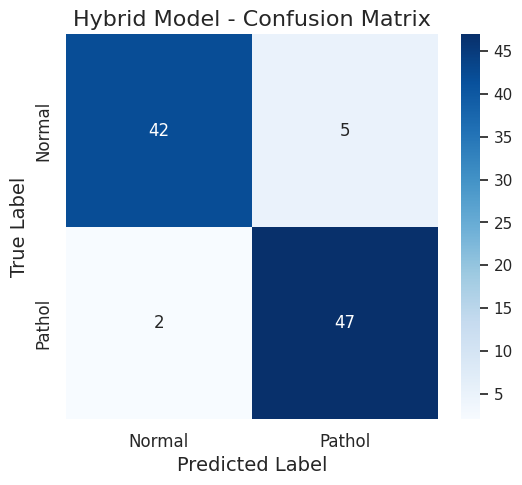

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step

Transfer Learning Model Test Metrics:
Accuracy: 0.9688
Precision: 0.9792
Recall: 0.9592
F1 Score: 0.9691


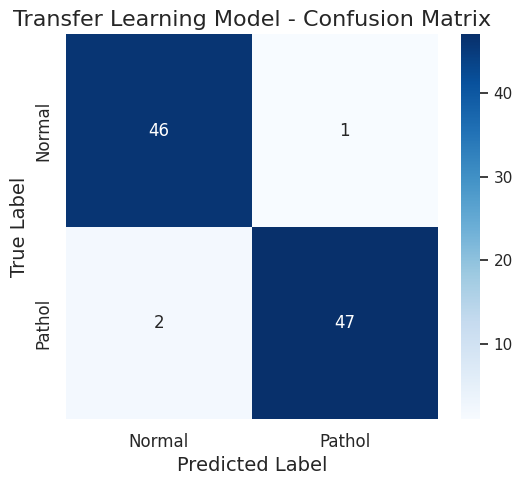

In [ ]:
import os
import glob
import numpy as np
import librosa
import librosa.display
from tensorflow.keras import layers, Model
from tensorflow.keras.applications import VGG16
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

# Set seaborn style
sns.set(style="whitegrid")

# Define paths
train_path = '/content/drive/MyDrive/Voice_2/Train'
test_path = '/content/drive/MyDrive/Voice_2/Test_2'  # <-- Test dataset path

classes = ['Normal', 'Pathol']
labels = {'Normal': 0, 'Pathol': 1}

# Define audio processing parameters
MAX_AUDIO_LENGTH = 16000  # 1 second at 16 kHz

# Function to extract Mel-spectrogram
def extract_mel_spectrogram(file_path, max_len=MAX_AUDIO_LENGTH):
    try:
        y, sr = librosa.load(file_path, sr=None)
        if len(y) < max_len:
            pad_width = max_len - len(y)
            y = np.pad(y, (0, pad_width), mode='constant')
        elif len(y) > max_len:
            y = y[:max_len]

        mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=64, fmax=8000)
        mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
        mel_spec_db = np.expand_dims(mel_spec_db, axis=-1)  # Add channel dim (64, time, 1)
        mel_spec_db_rgb = np.repeat(mel_spec_db, 3, axis=-1)  # Simulate RGB channels (64, time, 3)

    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        mel_spec_db_rgb = np.zeros((64, 100, 3))  # Placeholder in case of failure

    return mel_spec_db_rgb

# Function to load dataset
def load_data(base_path, classes, labels):
    features = []
    targets = []
    for class_name in classes:
        class_path = os.path.join(base_path, class_name, '*.wav')
        file_list = glob.glob(class_path)
        print(f"Processing {len(file_list)} files in class '{class_name}'")

        for file in file_list:
            mel_spec = extract_mel_spectrogram(file)
            features.append(mel_spec)
            targets.append(labels[class_name])

    return np.array(features), np.array(targets)

# Load test data
print("Loading test dataset...")
X_test, Y_test = load_data(test_path, classes, labels)
print(f"Test data shape: {X_test.shape}, Labels shape: {Y_test.shape}")

# Evaluate both models on the test set
def evaluate_model(model, model_name, X_test, Y_test):
    Y_pred_prob = model.predict(X_test)
    Y_pred = (Y_pred_prob > 0.5).astype(int).flatten()

    accuracy = accuracy_score(Y_test, Y_pred)
    precision = precision_score(Y_test, Y_pred)
    recall = recall_score(Y_test, Y_pred)
    f1 = f1_score(Y_test, Y_pred)
    cm = confusion_matrix(Y_test, Y_pred, labels=[0, 1])

    print(f"\n{model_name} Test Metrics:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Pathol'],
                yticklabels=['Normal', 'Pathol'])
    plt.title(f'{model_name} - Confusion Matrix', fontsize=16)
    plt.xlabel('Predicted Label', fontsize=14)
    plt.ylabel('True Label', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.show()

# Evaluate both models
evaluate_model(model_hyb, "Hybrid Model", X_test, Y_test)
evaluate_model(model_trans, "Transfer Learning Model", X_test, Y_test)

In [ ]:
def load_data(base_path, classes, labels):
    features = []
    targets = []
    file_paths = []  # To store the file paths

    for class_name in classes:
        class_path = os.path.join(base_path, class_name, '*.wav')
        file_list = glob.glob(class_path)
        print(f"Processing {len(file_list)} files in class '{class_name}'")

        for file in file_list:
            mel_spec = extract_mel_spectrogram(file)
            features.append(mel_spec)
            targets.append(labels[class_name])
            file_paths.append(file)  # Store the file path

    return np.array(features), np.array(targets), np.array(file_paths)
    print("Loading test dataset...")
X_test, Y_test, file_paths = load_data(test_path, classes, labels)
print(f"Test data shape: {X_test.shape}, Labels shape: {Y_test.shape}")
# Predict on the test set
Y_pred_prob = model_trans.predict(X_test)
Y_pred = (Y_pred_prob > 0.5).astype(int).flatten()

# Identify incorrectly predicted Pathol samples
incorrect_pathol_files = []

for i in range(len(Y_test)):
    if Y_test[i] == 1 and Y_pred[i] == 0:  # True label is Pathol, predicted as Normal
        incorrect_pathol_files.append(file_paths[i])

# Print the list of incorrectly predicted Pathol files
print("\nIncorrectly predicted Pathol files:")
for file in incorrect_pathol_files:
    print(file)

Processing 30 files in class 'Normal'
Processing 29 files in class 'Pathol'
Test data shape: (59, 64, 32, 3), Labels shape: (59,)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


/usr/local/lib/python3.11/dist-packages/librosa/feature/spectral.py:2148: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)



Incorrectly predicted Pathol files:
/content/drive/MyDrive/Voice_2/Test/Pathol/A1-1300D7FyWy-cyt-m-10-n-496364-kaf-3-p.wav


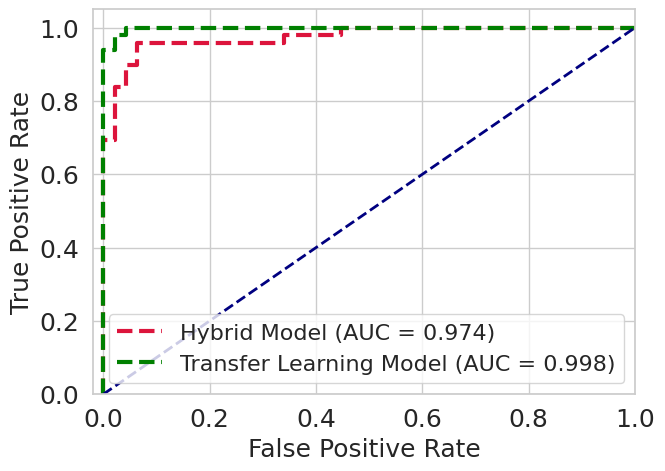

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Calculate ROC curve and AUC for model_1 (assuming sigmoid output)
fpr_1, tpr_1, _ = roc_curve(Y_val, Y_val_pred_prob_1)  # Use predicted probabilities from model_1
roc_auc_1 = roc_auc_score(Y_val, Y_val_pred_prob_1)

# Calculate ROC curve and AUC for model_2 (assuming sigmoid output)
fpr_2, tpr_2, _ = roc_curve(Y_val, Y_val_pred_prob_2)  # Use predicted probabilities from model_2
roc_auc_2 = roc_auc_score(Y_val, Y_val_pred_prob_2)

# Create a single figure
plt.figure(figsize=(7,5))

# Plot ROC curve for model_1
plt.plot(fpr_1, tpr_1, label=f'Hybrid Model (AUC = {roc_auc_1:.3f})', linestyle='--', linewidth=3, color='crimson')

# Plot ROC curve for model_2
plt.plot(fpr_2, tpr_2, label=f'Transfer Learning Model (AUC = {roc_auc_2:.3f})', linestyle='--', linewidth=3, color='green')

# Plot the diagonal line (random classifier reference)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--', linewidth=2)

# Add title, labels, and legend

plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.xlim([-0.02, 1.0])  # Adjust x-axis limits to start from -0.02
plt.ylim([0.0, 1.05])   # Adjust y-axis limits
plt.tick_params(axis='both', which='major', labelsize=18)
plt.legend(loc="lower right", fontsize=16)
plt.grid(True)

# Show the combined figure
plt.show()

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score

# Predict on the validation set
Y_val_pred_prob = model_hyb.predict(X_val)
Y_val_pred = (Y_val_pred_prob > 0.5).astype(int).flatten()  # Convert probabilities to binary predictions

# Calculate precision, recall, and F1 score for each class
precision = precision_score(Y_val, Y_val_pred, average=None)
recall = recall_score(Y_val, Y_val_pred, average=None)
f1 = f1_score(Y_val, Y_val_pred, average=None)

# Print precision, recall, and F1 score for each class
for i, class_name in enumerate(['Normal', 'Pathol']):
    print(f"Precision for {class_name}: {precision[i]:.2f}")
    print(f"Recall for {class_name}: {recall[i]:.2f}")
    print(f"F1 Score for {class_name}: {f1[i]:.2f}")

# Print overall metrics as well
accuracy = accuracy_score(Y_val, Y_val_pred)
print(f"\nOverall Accuracy: {accuracy:.2f}")
print(f"Overall F1 Score: {f1.mean():.2f}")


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Precision for Normal: 0.95
Recall for Normal: 0.89
F1 Score for Normal: 0.92
Precision for Pathol: 0.90
Recall for Pathol: 0.96
F1 Score for Pathol: 0.93

Overall Accuracy: 0.93
Overall F1 Score: 0.93


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score

# Predict on the validation set
Y_val_pred_prob = model_trans.predict(X_val)
Y_val_pred = (Y_val_pred_prob > 0.5).astype(int).flatten()  # Convert probabilities to binary predictions

# Calculate precision, recall, and F1 score for each class
precision = precision_score(Y_val, Y_val_pred, average=None)
recall = recall_score(Y_val, Y_val_pred, average=None)
f1 = f1_score(Y_val, Y_val_pred, average=None)

# Print precision, recall, and F1 score for each class
for i, class_name in enumerate(['Normal', 'Pathol']):
    print(f"Precision for {class_name}: {precision[i]:.2f}")
    print(f"Recall for {class_name}: {recall[i]:.2f}")
    print(f"F1 Score for {class_name}: {f1[i]:.2f}")

# Print overall metrics as well
accuracy = accuracy_score(Y_val, Y_val_pred)
print(f"\nOverall Accuracy: {accuracy:.2f}")
print(f"Overall F1 Score: {f1.mean():.2f}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Precision for Normal: 0.96
Recall for Normal: 0.98
F1 Score for Normal: 0.97
Precision for Pathol: 0.98
Recall for Pathol: 0.96
F1 Score for Pathol: 0.97

Overall Accuracy: 0.97
Overall F1 Score: 0.97


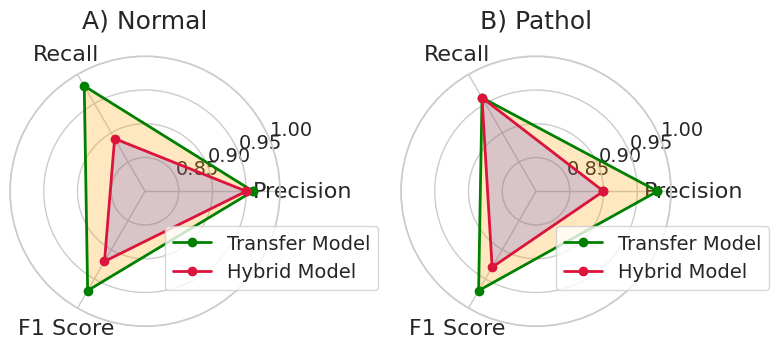

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define the metrics for each model
metrics = ['Precision', 'Recall', 'F1 Score']

# Metrics for NORM class
transfer_model_norm = [0.96, 0.98, 0.97]  # Precision, Recall, F1 Score
hybrid_model_norm = [0.95, 0.89, 0.92]

# Metrics for PATHOL class
transfer_model_pathol = [0.98, 0.96, 0.97]
hybrid_model_pathol = [0.90, 0.96, 0.93]

# Function to create a radar plot
def create_radar_plot(ax, data_1, data_2, labels, title):
    # Number of variables (metrics)
    num_vars = len(labels)

    # Compute angle for each axis
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    angles += angles[:1]  # Complete the loop

    # Extend data to complete the loop
    data_1 += data_1[:1]
    data_2 += data_2[:1]

    # Plot data for Transfer Model
    ax.plot(angles, data_1, label='Transfer Model', linewidth=2, linestyle='solid', marker='o', color='green')
    ax.fill(angles, data_1, alpha=0.25, color='orange')

    # Plot data for Hybrid Model
    ax.plot(angles, data_2, label='Hybrid Model', linewidth=2, linestyle='solid', marker='o', color='crimson')
    ax.fill(angles, data_2, alpha=0.15, color='blue')

    # Add labels to the axes
    ax.set_thetagrids(np.degrees(angles[:-1]), labels, fontsize=16)
    ax.set_ylim(0, 1)  # Set y-axis limits between 0 and 1

    # Add title and legend
    ax.set_title(title, fontsize=18, pad=20)
    ax.legend(loc='lower right', bbox_to_anchor=(1.4, 0.1), fontsize=14)
    ax.tick_params(axis='y', labelsize=14)
    ax.set_ylim(0.80, 1.00)

# Create a figure with one row and two columns of subplots
fig, axes = plt.subplots(1, 2, figsize=(8, 6), subplot_kw=dict(polar=True))

# Create radar plot for NORM class
create_radar_plot(
    axes[0],
    transfer_model_norm,
    hybrid_model_norm,
    metrics,
    title="A) Normal"
)

# Create radar plot for PATHOL class
create_radar_plot(
    axes[1],
    transfer_model_pathol,
    hybrid_model_pathol,
    metrics,
    title="B) Pathol"
)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the combined figure
plt.show()

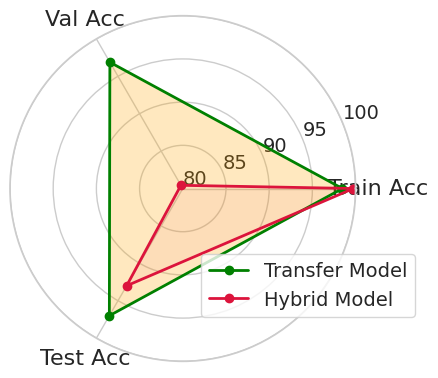

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Data from your table
labels = ['Train Acc', 'Val Acc', 'Test Acc']
transfer_model = [98.48, 96.88, 97.00]
hybrid_model = [99.75, 80.43, 93.00]

def create_radar_plot(ax, data_1, data_2, labels, title):
    num_vars = len(labels)
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    angles += angles[:1]  # Close the loop

    # Extend data to close the loop
    data_1 += data_1[:1]
    data_2 += data_2[:1]

    # Plot data for Transfer Model
    ax.plot(angles, data_1, label='Transfer Model', linewidth=2, linestyle='solid', marker='o', color='green')
    ax.fill(angles, data_1, alpha=0.25, color='orange')

    # Plot data for Hybrid Model
    ax.plot(angles, data_2, label='Hybrid Model', linewidth=2, linestyle='solid', marker='o', color='crimson')
    ax.fill(angles, data_2, alpha=0.05, color='crimson')

    # Add angular axis labels
    ax.set_thetagrids(np.degrees(angles[:-1]), labels, fontsize=16)

    # Set radial limits
    ax.set_ylim(80, 100)

    # Set exactly 5 radial ticks
    radial_ticks = np.linspace(80, 100, 5)
    ax.set_yticks(radial_ticks)
    ax.set_yticklabels([f"{int(t)}" for t in radial_ticks])  # Format as integers
    ax.tick_params(axis='y', labelsize=14)

    # Title
    ax.set_title(title, fontsize=18, pad=20)

    # Legend
    ax.legend(loc='lower right', bbox_to_anchor=(1.2, 0.1), fontsize=14)

# Create figure and single polar subplot
fig, ax = plt.subplots(figsize=(6, 4), subplot_kw=dict(polar=True))

# Generate radar plot
create_radar_plot(ax, transfer_model, hybrid_model, labels, title="")

# Adjust layout to prevent clipping
plt.tight_layout()

# Show the plot
plt.show()